In [22]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import plot, show, savefig, xlim, figure,  ylim, legend, boxplot, setp, axes

import copy

from sklearn.cluster import Birch
from sklearn import metrics
from sklearn.metrics import pairwise_distances

from sklearn import decomposition
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.utils.testing import ignore_warnings
from sklearn.exceptions import ConvergenceWarning

import collections
@ignore_warnings(category=ConvergenceWarning)

def get_cal_score(data, labels):
    return metrics.calinski_harabasz_score(data, labels)

In [23]:
df = pd.read_csv('../data.csv')
df.shape

(288, 7)

In [24]:
columns = list(df.columns)
columns

['index',
 'totalCarNumber',
 'numberOfTrips',
 'median_overhead',
 'q1_overhead',
 'q3_overhead',
 'p9_overhead']

In [25]:
# df_before =df.iloc[144:, :]


# indexes = np.array_split(df_before.index,8, axis=0)
# for i,index in enumerate(indexes):
#     df_before.loc[index,'group'] = i
    
# df_before['c'] = df_before['group'].diff()
# df_filtered = df_before[df_before['c'] != 0]

# index_list = df_filtered.index.tolist() # list of the start poisitions of index for change of values 
# # print(len(index_list))
# # print('\n')
# # print(index_list)

# l_mod = index_list + [max(index_list)+1] # creating a list of indexes to iterate over (must have 0 in it)
# list_of_dfs = [df_before.iloc[l_mod[n]:l_mod[n+1]] for n in range(len(l_mod)-1)] # creating a list of dfs for each index

# # len(list_of_dfs)

/home/marta/env/lib/python3.6/site-packages/pandas-1.0.3-py3.6-linux-x86_64.egg/pandas/core/indexing.py:845: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/home/marta/env/lib/python3.6/site-packages/pandas-1.0.3-py3.6-linux-x86_64.egg/pandas/core/indexing.py:966: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s
/home/marta/env/lib/python3.6/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice

In [26]:
def plot_silhouette_scores(model, test_data, n_clusters_min, n_clusters_max, title):
    """ Plot silhouette scores and return the best number of clusters"""

    if len(model.subcluster_labels_) >= 2:

        silhouette_scores = []
        clusters_range = range(n_clusters_min, n_clusters_max+1)
        results_dict = []
        for number in clusters_range:
            # make a copy of the model so as not to mess up the 'correct' model
            model_cpy = copy.deepcopy(model)
            model_cpy.set_params(n_clusters=number)

            model_cpy.partial_fit()
            labels = model_cpy.predict(test_data)
            try: 
                s = metrics.silhouette_score(test_data, labels, metric='euclidean')
                silhouette_scores.append(s)
                results_dict.append((number, s))
            except ValueError:
                pass

        silhouette_range = [i[0] for i in results_dict]  
        max_score = max(silhouette_scores)
        for i in results_dict:
            if i[1] == max_score:
                print(max_score)
                return int(i[0])
    else:
        print(0)
        return n_clusters_min

In [27]:
def combine_dfs(df_list):
    return pd.concat(df_list)

In [28]:
def outliers_removal(df):
    data_split_modified_z = df[['median_overhead', 'q1_overhead', 'q3_overhead', 'p9_overhead', 'totalCarNumber', 'index']].copy()
    # to_drop = [252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264,265,266]
    # data_split_modified_z.drop(to_drop, inplace=True)
#     data_split_modified_z = data_split_modified_z.iloc[:144, :]
    data_split_modified_z = data_split_modified_z.to_numpy()
    data_split_modified_z_12 = np.split(data_split_modified_z, 1)
    indexes = [] 

    for d in range(len(data_split_modified_z_12)):
        ind = []
        k = len(data_split_modified_z_12[d])
        for i in [0, 1, 2, 3]:
            ys = data_split_modified_z_12[d][:,i] 
            median_y = np.median(ys)
            median_absolute_deviation_y = np.median([np.abs(y - median_y) for y in ys])
    #         print(median_absolute_deviation_y)
            for y in range(len(data_split_modified_z_12[d])):
                modified_z_score = 0.6745 * (data_split_modified_z_12[d][y, i] - median_y) / median_absolute_deviation_y
    #             z_score = (data_split[d][y, i]  - mean_ys) / std_ys
                if np.abs(modified_z_score) > 3.5:
                    ind.append(y)


        data_split_modified_z_12[d] = np.delete(data_split_modified_z_12[d], ind, axis=0)
#         print('Outliers detected: ' + str((k - len(data_split_modified_z_12[d]))))

    data_split_modified_z_12 = np.concatenate(data_split_modified_z_12, axis=0)
    return data_split_modified_z_12

In [32]:
data_split_modified_z = df[['median_overhead', 'q1_overhead', 'q3_overhead', 'p9_overhead', 'totalCarNumber', 'index']].copy()
data_split_modified_z = data_split_modified_z.iloc[144:, :]
data_split_modified_z = data_split_modified_z.to_numpy()
# data_split_modified_z_12 = data_split_modified_z.to_numpy()


# """ SIZE 12 """
data_split_modified_z_12 = np.split(data_split_modified_z, 8)
indexes = [] 

for d in range(len(data_split_modified_z_12)):
    ind = []
    k = len(data_split_modified_z_12[d])
    for i in [0, 1, 2, 3]:
        ys = data_split_modified_z_12[d][:,i] 
        median_y = np.median(ys)
        median_absolute_deviation_y = np.median([np.abs(y - median_y) for y in ys])
        for y in range(len(data_split_modified_z_12[d])):
            modified_z_score = 0.6745 * (data_split_modified_z_12[d][y, i] - median_y) / median_absolute_deviation_y
            if np.abs(modified_z_score) > 3.5:
                ind.append(y)


    data_split_modified_z_12[d] = np.delete(data_split_modified_z_12[d], ind, axis=0)

# data_split_modified_z_12 = np.concatenate(data_split_modified_z_12, axis=0)

In [36]:
len(list_of_nmpys_for_graphs)

8

# a day of data (no accident)

0.6878695648913413
0.6890174027423253
0.5440096755918096
0.4779349051420663
0.5915194452994936
0.6726985933643453
0.8277943811364668
0.7151233546749876
4
11
3
6
8
9
10
11


7
2
1
1
7
4
5
5


ValueError: 'c' argument has 15 elements, which is inconsistent with 'x' and 'y' with size 32.

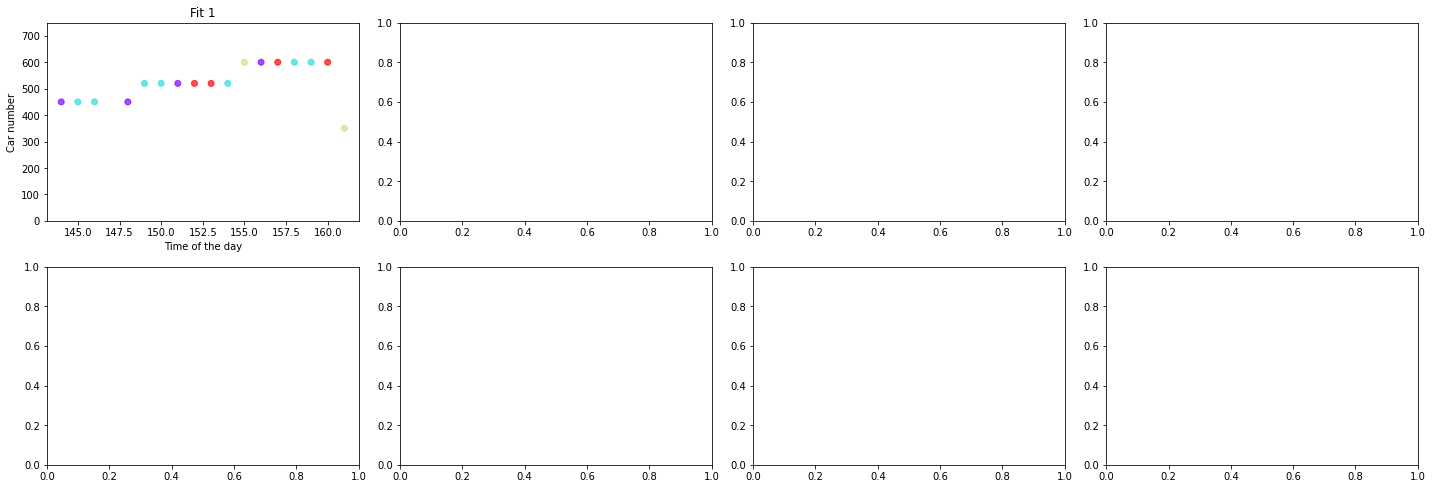

In [37]:
model_001_before = Birch(n_clusters=None, threshold=0.01)

list_of_nmpys_for_graphs = []

removed_outliers_numpy = []
list_of_nmpys_for_graphs = []

labels_dict = {}
label_1_dict = {}
label_0_dict = {}
add_data_to_this = pd.DataFrame(columns = columns)

fit_number = 1

list_of_dfs

for i in data_split_modified_z_12[:8]:
#     numpy_array = outliers_removal(list_of_dfs[i])
    
    model_001_before.partial_fit(i[:, :-2])
    
    model_copy = copy.deepcopy(model_001_before)
    
    removed_outliers_numpy.append(i)
    new_nmpy = np.concatenate(removed_outliers_numpy, axis=0)
    
    n = plot_silhouette_scores(model_copy, i[:, :-2], 2, 10, fit_number)
#     print(n)
    
    model_copy.set_params(n_clusters = n)
    model_copy.partial_fit()
    
    labels_dict[f'fit_{fit_number}'] = model_copy.predict(i[:, :-2])
    unique, counts = np.unique(labels_dict[f'fit_{fit_number}'], return_counts=True)
    label_1_dict[f'fit_{fit_number}'] = counts[1]
    label_0_dict[f'fit_{fit_number}'] = counts[0]
#     print(collections.Counter(labels_dict[f'fit_{fit_number}']))
#     print(get_cal_score(new_nmpy[:, :-2], labels_dict[f'fit_{fit_number}']))
    list_of_nmpys_for_graphs.append(new_nmpy)
    fit_number += 1
    
for i in label_0_dict.values():
    print(i)
    
print('\n')

for i in label_1_dict.values():
    print(i)
    
    
col_counter = 0
row_counter = 0

fit_number = 1

nrows = 2
ncols = 4

figure, axs = plt.subplots(nrows=nrows, ncols=ncols,figsize=(20,7.5))

for i in list_of_nmpys_for_graphs:
    
#     numpy_array = i.to_numpy()
    
    figure.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    axs[row_counter,col_counter].scatter(i[:, 5], i[:, 4], c =labels_dict[f'fit_{fit_number}'], cmap='rainbow', alpha=0.7 )
    axs[row_counter,col_counter].set_xlabel('Time of the day')
    axs[row_counter,col_counter].set_ylim(0, 750)
    axs[row_counter,col_counter].set_ylabel('Car number')
    axs[row_counter,col_counter].set_title(f'Fit {fit_number}')
    
    if fit_number >= 9:
        axs[row_counter,col_counter].axvline(x=143, color='g')
    if col_counter == (ncols-1):
        col_counter = 0
        row_counter += 1
    else:
        col_counter += 1
    
    fit_number += 1

In [ ]:
model_005_before = Birch(n_clusters=None, threshold=0.05)

list_of_nmpys_for_graphs = []

removed_outliers_numpy = []
list_of_nmpys_for_graphs = []

labels_dict = {}
label_1_dict = {}
label_0_dict = {}
add_data_to_this = pd.DataFrame(columns = columns)

fit_number = 1

list_of_dfs

for i in range(0, len(list_of_dfs)):
    numpy_array = outliers_removal(list_of_dfs[i])
    
    model_005_before.partial_fit(numpy_array[:, :-2])
    
    model_copy = copy.deepcopy(model_005_before)
    
    removed_outliers_numpy.append(numpy_array)
    new_nmpy = np.concatenate(removed_outliers_numpy, axis=0)
    
    n = plot_silhouette_scores(model_copy, new_nmpy[:, :-2], 2, 10, fit_number)
#     print(n)
    
    model_copy.set_params(n_clusters = n)
    model_copy.partial_fit()
    
    labels_dict[f'fit_{fit_number}'] = model_copy.predict(new_nmpy[:, :-2])
    unique, counts = np.unique(labels_dict[f'fit_{fit_number}'], return_counts=True)
    label_1_dict[f'fit_{fit_number}'] = counts[1]
    label_0_dict[f'fit_{fit_number}'] = counts[0]
#     print(collections.Counter(labels_dict[f'fit_{fit_number}']))
#     print(get_cal_score(new_nmpy[:, :-2], labels_dict[f'fit_{fit_number}']))
    list_of_nmpys_for_graphs.append(new_nmpy)
    fit_number += 1
    
print('\n')    
for i in label_0_dict.values():
    print(i)
    
print('\n')

for i in label_1_dict.values():
    print(i)

In [ ]:
model_1_before = Birch(n_clusters=None, threshold=0.1)

list_of_nmpys_for_graphs = []

removed_outliers_numpy = []
list_of_nmpys_for_graphs = []

labels_dict = {}
label_1_dict = {}
label_0_dict = {}
add_data_to_this = pd.DataFrame(columns = columns)

fit_number = 1

list_of_dfs

for i in range(0, len(list_of_dfs)):
    numpy_array = outliers_removal(list_of_dfs[i])
    
    model_1_before.partial_fit(numpy_array[:, :-2])
    
    model_copy = copy.deepcopy(model_1_before)
    
    removed_outliers_numpy.append(numpy_array)
    new_nmpy = np.concatenate(removed_outliers_numpy, axis=0)
    
    n = plot_silhouette_scores(model_copy, new_nmpy[:, :-2], 2, 10, fit_number)
#     print(n)
    
    model_copy.set_params(n_clusters = n)
    model_copy.partial_fit()
    
    labels_dict[f'fit_{fit_number}'] = model_copy.predict(new_nmpy[:, :-2])
    unique, counts = np.unique(labels_dict[f'fit_{fit_number}'], return_counts=True)
    label_1_dict[f'fit_{fit_number}'] = counts[1]
    label_0_dict[f'fit_{fit_number}'] = counts[0]
#     print(collections.Counter(labels_dict[f'fit_{fit_number}']))
#     print(get_cal_score(new_nmpy[:, :-2], labels_dict[f'fit_{fit_number}']))
    list_of_nmpys_for_graphs.append(new_nmpy)
    fit_number += 1
print('\n')

for i in label_0_dict.values():
    print(i)
    
print('\n')

for i in label_1_dict.values():
    print(i)

In [ ]:
model_02_before = Birch(n_clusters=None, threshold=0.2)

list_of_nmpys_for_graphs = []

removed_outliers_numpy = []
list_of_nmpys_for_graphs = []

labels_dict = {}
label_1_dict = {}
label_0_dict = {}
add_data_to_this = pd.DataFrame(columns = columns)

fit_number = 1

list_of_dfs

for i in range(0, len(list_of_dfs)):
    numpy_array = outliers_removal(list_of_dfs[i])
    
    model_02_before.partial_fit(numpy_array[:, :-2])
    
    model_copy = copy.deepcopy(model_02_before)
    
    removed_outliers_numpy.append(numpy_array)
    new_nmpy = np.concatenate(removed_outliers_numpy, axis=0)
    
    n = plot_silhouette_scores(model_copy, new_nmpy[:, :-2], 2, 10, fit_number)
#     print(n)
    
    model_copy.set_params(n_clusters = n)
    model_copy.partial_fit()
    
    labels_dict[f'fit_{fit_number}'] = model_copy.predict(new_nmpy[:, :-2])
    unique, counts = np.unique(labels_dict[f'fit_{fit_number}'], return_counts=True)
    label_1_dict[f'fit_{fit_number}'] = counts[1]
    label_0_dict[f'fit_{fit_number}'] = counts[0]
#     print(collections.Counter(labels_dict[f'fit_{fit_number}']))
#     print(get_cal_score(new_nmpy[:, :-2], labels_dict[f'fit_{fit_number}']))
    list_of_nmpys_for_graphs.append(new_nmpy)
    fit_number += 1
    
print('\n')
    
for i in label_0_dict.values():
    print(i)
    
print('\n')

for i in label_1_dict.values():
    print(i)

col_counter = 0
row_counter = 0

fit_number = 1

nrows = 4
ncols = 4

figure, axs = plt.subplots(nrows=nrows, ncols=ncols,figsize=(14,14))

for i in list_of_nmpys_for_graphs:
    
#     numpy_array = i.to_numpy()
    
    figure.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    axs[row_counter,col_counter].scatter(i[:, 5], i[:, 4], c =labels_dict[f'fit_{fit_number}'], cmap='rainbow', alpha=0.7 )
    axs[row_counter,col_counter].set_xlabel('Time of the day')
    axs[row_counter,col_counter].set_ylim(0, 750)
    axs[row_counter,col_counter].set_ylabel('Car number')
    axs[row_counter,col_counter].set_title(f'Fit {fit_number}')
    
    if fit_number >= 9:
        axs[row_counter,col_counter].axvline(x=143, color='g')
    if col_counter == (ncols-1):
        col_counter = 0
        row_counter += 1
    else:
        col_counter += 1
    
    fit_number += 1

In [ ]:
model_3_before = Birch(n_clusters=None, threshold=0.3)

list_of_nmpys_for_graphs = []

removed_outliers_numpy = []
list_of_nmpys_for_graphs = []

labels_dict = {}
label_1_dict = {}
label_0_dict = {}
add_data_to_this = pd.DataFrame(columns = columns)

fit_number = 1

list_of_dfs

for i in range(0, len(list_of_dfs)):
    numpy_array = outliers_removal(list_of_dfs[i])
    
    model_3_before.partial_fit(numpy_array[:, :-2])
    
    model_copy = copy.deepcopy(model_3_before)
    
    removed_outliers_numpy.append(numpy_array)
    new_nmpy = np.concatenate(removed_outliers_numpy, axis=0)
    
    n = plot_silhouette_scores(model_copy, new_nmpy[:, :-2], 2, 10, fit_number)
#     print(n)
    
    model_copy.set_params(n_clusters = n)
    model_copy.partial_fit()
    
    labels_dict[f'fit_{fit_number}'] = model_copy.predict(new_nmpy[:, :-2])
    unique, counts = np.unique(labels_dict[f'fit_{fit_number}'], return_counts=True)
    try:
        label_1_dict[f'fit_{fit_number}'] = counts[1]
    except:
        label_1_dict[f'fit_{fit_number}'] = 0
    label_0_dict[f'fit_{fit_number}'] = counts[0]
#     print(collections.Counter(labels_dict[f'fit_{fit_number}']))
#     print(get_cal_score(new_nmpy[:, :-2], labels_dict[f'fit_{fit_number}']))
    list_of_nmpys_for_graphs.append(new_nmpy)
    fit_number += 1
    
print('\n')
for i in label_0_dict.values():
    print(i)
    
print('\n')

for i in label_1_dict.values():
    print(i)

In [ ]:
model_5_before = Birch(n_clusters=None, threshold=0.5)

list_of_nmpys_for_graphs = []

removed_outliers_numpy = []
list_of_nmpys_for_graphs = []

labels_dict = {}
label_1_dict = {}
label_0_dict = {}
add_data_to_this = pd.DataFrame(columns = columns)

fit_number = 1

list_of_dfs

for i in range(0, len(list_of_dfs)):
    numpy_array = outliers_removal(list_of_dfs[i])
    
    model_5_before.partial_fit(numpy_array[:, :-2])
    
    model_copy = copy.deepcopy(model_5_before)
    
    removed_outliers_numpy.append(numpy_array)
    new_nmpy = np.concatenate(removed_outliers_numpy, axis=0)
    
    n = plot_silhouette_scores(model_copy, new_nmpy[:, :-2], 2, 10, fit_number)
#     print(n)
    
    model_copy.set_params(n_clusters = n)
    model_copy.partial_fit()
    
    labels_dict[f'fit_{fit_number}'] = model_copy.predict(new_nmpy[:, :-2])
    unique, counts = np.unique(labels_dict[f'fit_{fit_number}'], return_counts=True)
    try:
        label_1_dict[f'fit_{fit_number}'] = counts[1]
    except:
        label_1_dict[f'fit_{fit_number}'] = 0
    label_0_dict[f'fit_{fit_number}'] = counts[0]
#     print(collections.Counter(labels_dict[f'fit_{fit_number}']))
#     print(get_cal_score(new_nmpy[:, :-2], labels_dict[f'fit_{fit_number}']))
    list_of_nmpys_for_graphs.append(new_nmpy)
    fit_number += 1

print('\n')
for i in label_0_dict.values():
    print(i)
    
print('\n')

for i in label_1_dict.values():
    print(i)